<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Práctico </h1>
<h3> Análisis y Visualización de Datos - 2020 </h3>

Durante este práctico vamos a trabajar sobre el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato. Este índice mide en detalle lo que entendemos como libertad, utilizando 79 indicadores de libertad personal y económica en distintos aspectos, hasta obtener un hermoso numerito del 1 al 10.

Las variables más importantes sobre las que trabaja el dataset son:

* Rule of Law
* Security and Safety
* Movement
* Religion
* Association, Assembly, and Civil Society
* Expression and Information
* Identity and Relationships
* Size of Government
* Legal System and Property Rights
* Access to Sound Money
* Freedom to Trade Internationally
* Regulation of Credit, Labor, and Business

Nosotros centrarermos nuestro análisis en variables relacionadas a *Identity and Relationships* en paises de Latinoamérica, y los compararemos con las estadísticas globales. La pregunta a responder es simple: **¿Qué niveles de libertad se viven en Latinoamérica, especificamente en cuanto libertades de indentidad?**. Sin embargo, para hacer un análisis de los datos tenemos que platear también estas sub preguntas:

1. ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.
2. ¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?
3. En este estudio, la libertad se mide con un estimadores principal: *hf_score* que hace referencia a Human Freedom, que a su vez está calculado en base a dos otros estimadores *ef_score*, para Economic Freedom y *pf_score*, para Personal Freedom. Estos tres estimadores, ¿se relacionan de la misma manera con la libertad de identidad?

Inicialmente, en toda exploración de datos tenemos muy poca información a priori sobre el significado de los datos y tenemos que empezar por comprenderlos. Les proponemos los siguientes ejercicios como guía para comenzar esta exploración.

In [23]:
import io
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas
import pandas as pd
import seaborn
import seaborn as sns
from scipy import stats


Si un archivo está disponible en la web, podemos leerlo con pandas utilizando su URL sin necesidad de descargarlo.

In [2]:
dataset = pandas.read_csv(
    'https://object.cato.org/sites/cato.org/files/human-freedom-index-files/human-freedom-index-2019.csv')
dataset.shape

(1620, 120)

Por suerte las columnas tienen un prefijo que nos aayuda a identificar a qué sección pertenecen. Nos quedamos sólo con las que comienzan con *pf_indentity*, junto con otras columnas más generales

In [5]:
score_cols = [col for col in dataset.columns if 'pf_identity' in col] + [
    'pf_score', # Personal Freedom (score)
    'pf_rank', # Personal Freedom (rank)
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

important_cols = ['year', 'ISO_code', 'countries', 'region'] + score_cols

In [6]:
dataset[important_cols]

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0,10,10,10,7.5,5.8,8.01,46,7.67,30,7.84,38
1,2017,DZA,Algeria,Middle East & North Africa,-,0,0,0,0,0,5.2,146,4.77,159,4.99,155
2,2017,AGO,Angola,Sub-Saharan Africa,10,0,0,0,5,5,5.98,121,4.83,158,5.4,151
3,2017,ARG,Argentina,Latin America & the Caribbean,10,10,10,10,10,10,8.04,41,5.67,147,6.86,77
4,2017,ARM,Armenia,Caucasus & Central Asia,7,10,10,10,7.5,8.2,7.15,72,7.7,27,7.42,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,-,10,10,10,10,10,9.29,7,8.18,6,8.73,4
1616,2008,DNK,Denmark,Western Europe,-,10,10,10,10,10,9.49,3,7.98,9,8.73,4
1617,2008,CHE,Switzerland,Western Europe,-,10,10,10,10,10,9.31,6,8.35,4,8.83,3
1618,2008,NZL,New Zealand,Oceania,-,10,10,10,10,10,9.42,4,8.46,3,8.94,2


Si analizamos los tipos, vemos que casi todas las columnas se leen como objetos debido a que los valores nulos están marcados con `-`. Los vamos a eliminar y volveremos a convertir las columnas con puntajes a tipo numérico.

In [7]:
dataset = dataset[important_cols].replace('-', numpy.nan)
for score_col in score_cols:
  dataset[score_col] = pandas.to_numeric(dataset[score_col])
dataset

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.29,7.0,8.18,6.0,8.73,4.0
1616,2008,DNK,Denmark,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.49,3.0,7.98,9.0,8.73,4.0
1617,2008,CHE,Switzerland,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.31,6.0,8.35,4.0,8.83,3.0
1618,2008,NZL,New Zealand,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.42,4.0,8.46,3.0,8.94,2.0


Ahora que las columnas tienen el tipo correcto, vamos a ver un pantallaso de las variables


In [8]:
seaborn.set_context(context='talk', font_scale=1.2)

# ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.

---


## RESPECTO A HF

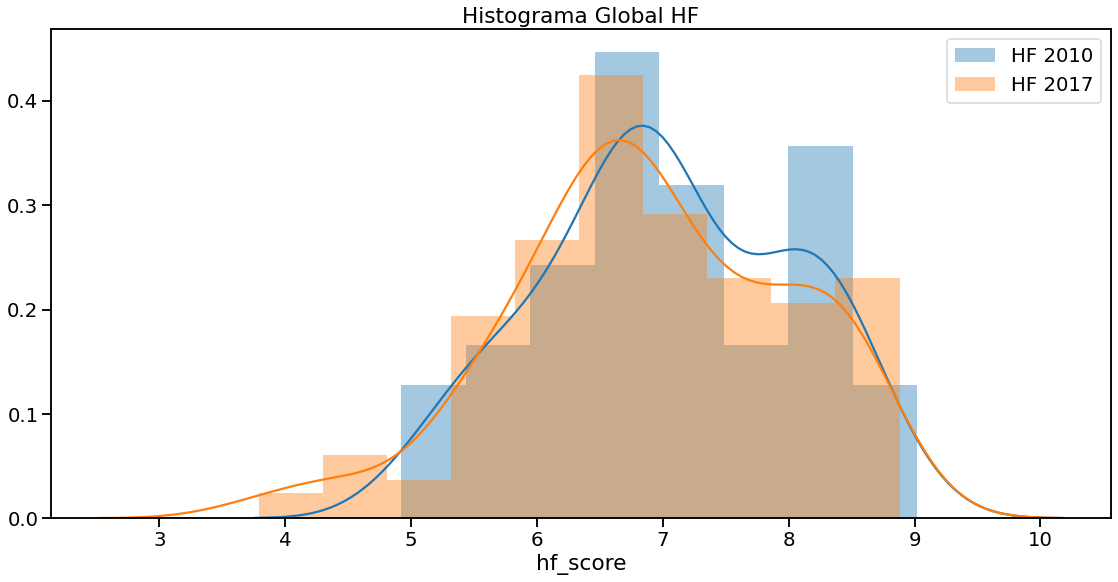

In [9]:
plt.figure(figsize=(19,9))
plt.title("Histograma Global HF")

min_year = 2010 #min(dataset.year.unique()) 
seaborn.distplot(
    dataset[dataset.year==min_year].hf_score, 
    label="HF {}".format(min_year)
    )

max_year = 2017 #max(dataset.year.unique()) 
seaborn.distplot(
    dataset[dataset.year==max_year].hf_score, 
    label="HF {}".format(max_year)
    )

plt.legend()

**Descripcion del primer año**

In [10]:
print("Descipcion HF {}".format(min_year))
print(dataset[dataset.year==min_year].hf_score.describe())
data = dataset[dataset.year==min_year].hf_score.dropna()
print("HF < 4.5 = {}%".format(
    100*len(data[data < 4.5]) / len(data)
))
 

Descipcion HF 2010
count    153.000000
mean       7.035294
std        0.997250
min        4.920000
25%        6.360000
50%        6.960000
75%        7.880000
max        9.020000
Name: hf_score, dtype: float64
HF < 4.5 = 0.0%


**Descripcion del ultimo año**


In [11]:
print("Descipcion HF {}".format(max_year))
print(dataset[dataset.year==max_year].hf_score.describe())
data = dataset[dataset.year==max_year].hf_score.dropna()
print("HF < 4.5 = {}%".format(
    100*len(data[data < 4.5]) / len(data)
))

Descipcion HF 2017
count    162.000000
mean       6.887963
std        1.104117
min        3.790000
25%        6.212500
50%        6.825000
75%        7.740000
max        8.880000
Name: hf_score, dtype: float64
HF < 4.5 = 3.0864197530864197%


De este primer pantallazo vemos que un valor de 4.5 esta muy por debajo de la media global. 
En el año 2008 todos los países de la muestra tenían un índice de libertad por encima de 4.5.

En el ultimo año (2017), alrededor del 3% de los países presentaron valores de human freedom por debajo de 4.5. Es decir que la libertad humana ha disminuido por debajo del límite 4.5 en pocos países a lo largo del tiempo.

##  RESPECTO A PF_IDENTITY

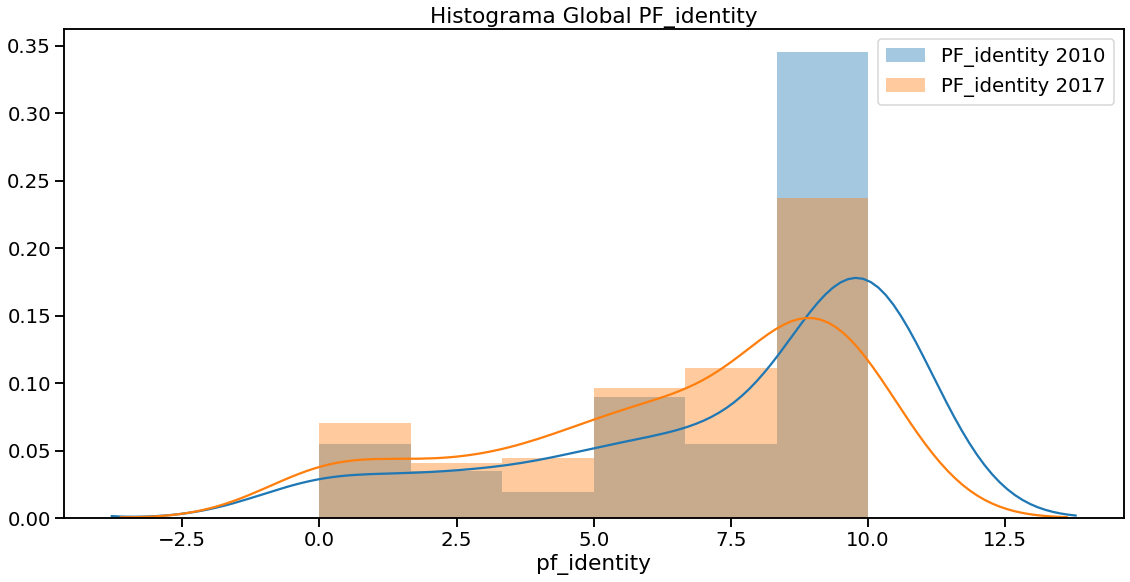

In [12]:
plt.figure(figsize=(19,9))
plt.title("Histograma Global PF_identity")

min_year = 2010 #min(dataset.year.unique()) 
seaborn.distplot(
    dataset[dataset.year==min_year].pf_identity, 
    label="PF_identity {}".format(min_year)
    )


max_year = 2017 #max(dataset.year.unique()) 
seaborn.distplot(
    dataset[dataset.year==max_year].pf_identity, 
    label="PF_identity {}".format(max_year)
    )


plt.legend()

**Descripcion del primer año**

In [13]:
print("Descipcion PF_Identity {}".format(min_year))
print(dataset[dataset.year==min_year].pf_identity.describe())
data = dataset[dataset.year==min_year].pf_identity.dropna()
print("PF_identity < 4.5 = {}%".format(
    100*len(data[data < 4.5]) / len(data)
))
 

Descipcion PF_Identity 2010
count    153.000000
mean       7.485621
std        3.258197
min        0.000000
25%        5.000000
50%        8.800000
75%       10.000000
max       10.000000
Name: pf_identity, dtype: float64
PF_identity < 4.5 = 18.30065359477124%


**Descripcion del ultimo año**


In [14]:
print("Descipcion PF_Identity {}".format(min_year))
print(dataset[dataset.year==max_year].pf_identity.describe())
data = dataset[dataset.year==max_year].pf_identity.dropna()
print("PF_identity < 4.5 = {}%".format(
    100*len(data[data < 4.5]) / len(data)
))

Descipcion PF_Identity 2010
count    162.000000
mean       6.496914
std        3.153908
min        0.000000
25%        4.350000
50%        7.500000
75%        9.000000
max       10.000000
Name: pf_identity, dtype: float64
PF_identity < 4.5 = 25.308641975308642%


En este primer pantallazo sobre la variable pf_identity vemos que esta distribuida sobre todo el rango, a diferencia de la anterior. En el primer año (2008) aprox 15% de los paises tenian un indice de libertad de identidad por debajo de 4.5, si bien este valor esta alejado de la media (7.72) es un valor representativo de la pobracion **(¿?)**. En 2008 la mitad de los países presentaba valores máximo del índice de libertad personal asociada a identidad (Esto llama la atención: comparar cómo se medía en 2008 y 2017 la libertad personal que tiene que ver con los diferentes indicadores de identidad).

En el ultimo año (2017) aprox. 25% de los paises estan por debajo de 4.5, lo que virtualmente representa el primer cuartil. esta mucho mas cercano a la media

# ¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?

---

En ambos anaisis parece haber un decrecimiento de las libertades humanas a nivel global, 
esto se da en el indice HF pero hay una tendencia decreciente aun mas fuerte en el indice de libertad de identidad.
pf_identity ver cuestiones legales que puedan haber cambiado a lo largo de los años.

# Parte 1
---

Luego de las clases del primer fin de semana, ya tenemos las herramientas para responder las siguientes preguntas:

## 1. Estadísticos descriptivos

  1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.
  3. Para cada país, tenemos varias realizaciones para cada variable *pf_identity* y *hf_score*. Si queremos comparar un país con otro, ¿cuál es la manera adecuada de hacerlo? Por ejemplo, ¿nos quedamos con un único valor? ¿o comparamos todos los valores? ¿usamos el promedio? ¿usamos la mediana? 
  2. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. Usar la respuesta del punto anterior para justificar si la comparación es válida o no.
  3. ¿Tiene sentido calcular la moda?
  4. ¿Cómo pueden sanearse los valores faltantes?
  5. ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? Los outliers, ¿son globales o por grupo? ¿Los eliminaría del conjunto de datos?
  
  

### 1.1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.


Calcularemos el valor mínimo, el máximo, el rango, algunos percentiles, el n de nuestra muestra (países por años), así como el rango intercuartílico para cada una de las variables en el mundo incluyendo todos los años (es decir, un pool desde 2008 a 2017). Además, utilizaremos la función .unique() para conocer los valores posibles de cada variable.

In [15]:
#Para el Mundo incluyendo todos los años (2008-2017)
cols = [col for col in dataset.columns if 'pf_identity' in col] + [
    'pf_score', # Personal Freedom (score)
    'ef_score', # Economic Freedom (score)
    'hf_score', # Human Freedom (score)
    'year'
]

ranges = pd.DataFrame()
ranges['min'] = dataset[cols].min()
ranges['max'] = dataset[cols].max()
ranges['range'] = ranges['max'] - ranges['min']
ranges['q25'] = dataset[cols].quantile(.25)
ranges['q50'] = dataset[cols].quantile(.50)
ranges['q70'] = dataset[cols].quantile(.70)
ranges['q75'] = dataset[cols].quantile(.75)
ranges['range_intercuartil'] = ranges['q75'] - ranges['q25']
ranges['count'] = dataset[cols].count()
ranges

,min,max,range,q25,q50,q70,q75,range_intercuartil,count
pf_identity_legal,0.00,10.00,10.00,7.0000,7.000,10.00,10.00,3.0000,308
pf_identity_sex_male,0.00,10.00,10.00,0.0000,10.000,10.00,10.00,10.0000,1537
pf_identity_sex_female,0.00,10.00,10.00,10.0000,10.000,10.00,10.00,0.0000,1540
pf_identity_sex,0.00,10.00,10.00,5.0000,10.000,10.00,10.00,5.0000,1540
pf_identity_divorce,0.00,10.00,10.00,5.0000,10.000,10.00,10.00,5.0000,1519
pf_identity,0.00,10.00,10.00,5.0000,8.800,10.00,10.00,5.0000,1540
pf_score,2.22,9.56,7.34,6.1475,7.145,8.05,8.38,2.2325,1540
ef_score,2.58,9.11,6.53,6.2200,6.880,7.34,7.44,1.2200,1540
hf_score,3.69,9.12,5.43,6.2800,6.900,7.65,7.88,1.6000,1540
year,2008.00,2017.00,9.00,2010.0000,2012.500,2014.30,2015.00,5.0000,1620


Utilizando la función `unique()` vemos que las diferentes variables que constituyen la libertad de identidad (`pf_identity_legal`, `pf_identity_sex`, `pf_identity_sex_male`, `pf_identity_sex_female` y `pf_identity_divorce`), pueden tomar sólo algunos pocos valores, es decir que son variables discretas (lo confirmamos en el 
[manual](https://www.cato.org/sites/cato.org/files/human-freedom-index-files/cato-human-freedom-index-update-3.pdf),
 pag. 393-392). 

Contrariamente, las variables como `pf_identity` general y todos los puntajes (i.e. `pf_score`, `ef_score`, `hf_score`) que resultan de operaciones a partir de estas variables discretas (y otras) sí parecen parecen variables continuas.


```python
[dataset.pf_identity_legal.unique()]+[
dataset.pf_identity_sex_male.unique()]+[
dataset.pf_identity_sex_female.unique()]+[
dataset.pf_identity_sex.unique()]+[
dataset.pf_identity_divorce.unique()]+[
dataset.pf_identity.unique()]+[
dataset.pf_score.unique()]+[
dataset.ef_score.unique()]+[
dataset.hf_score.unique()]
```

Considerando estos dos análisis vemos que todas las variables discretas referidas a la libertad de identidad toman valores entre 0 y 10. Específicamente:

`pf_identity_legal` puede tomar los valores: 0, 7, 10 ó `nan` cuando no se cuentan registros para la variable (más adelante demostraremos que los valores `nan` de esta variable ocurren para el período comprendido entre 2008 y 2014. Es decir que esta variable comenzó a participar del promedio `pf_identity` recién a partir de 2015. Esto explica el bajo conteo o tamaño muestra que obtenemos para esta variable comparado a las otras). Como no hemos agrupado estos datos por año, no podemos asumir que los porcentajes que discutiremos a continuación representan países (es decir, representan países a lo largo de los años), sin emabrgo nos sirven para una primera exploración de los datos. La mayoría de los datos se encuentran entre 7 y 10 (rango intercuartílico). Sin embargo, al menos la mitad de los datos (percentil .50 o mediana) representan pasíses para los que no está permitido el cambio de género o no se pemiten ciertos tratamientos médicos para el mismo (valores 0 y 7 de la variable, respectivamente). Por otro lado, alrededor del 30% de los datos corresponden a países en los que no existen requerimientos para el cambio de género (los datos que quedan por encima del percentil .70 con valor 10). Utilizando una función `count()` podríamos conocer exactamente qué cantidad de casos o entradas existen para cada uno de los valores posibles de la variable:

```python
FrecDiscretas0=(dataset.pf_identity_legal[dataset.pf_identity_legal== 0.]).count()
FrecDiscretas7=(dataset.pf_identity_legal[dataset.pf_identity_legal== 7.]).count()
FrecDiscretas10=(dataset.pf_identity_legal[dataset.pf_identity_legal== 10.]).count()
FrecDiscretasNAN=(dataset.pf_identity_legal[dataset.pf_identity_legal=='nan']).count()

```
Las variables `pf_identity_sex_male`, `pf_identity_sex`, `pf_identity_sex_female` pueden tomar los valores: 0, 5, 10 ó `nan` cuando no se cuentan registros para la variable. Para las tres variables, el valor más frecuente es 10, es decir, que relaciones homosexuales son legales en todo el país. Específicamente para la variable `sex_male` se registraron unas 1025 entradas/casos con valor 10 y 502 con valor 0. Para `sex_female`, se registró una mayor cantidad de entradas/casos con valor 10 (n=1215) y y menor cantidad de entradas/casos con valor 0 (n=315). Como promedio de ambas, la variable `_sex`  registró con valor 10 y con valor 0 en 1028 y 315 casos, respectivamente. 

La variable `pf_identity_divorce` puede tomar los valores (`[ 7.5,  0. ,  5. , 10. ,  2.5,  nan]`). Más de la mitad de los datos presentaron valores iguales a 10, representando países en los que las muejeres tiene el mismo derecho que los hombres para iniciar el divorcio y los mismos requerimeintos para finalizarlo, sin repercusión sobre su autoridad parental.

`pf_score` es una variable continua, en la que la mayoría de los registros se encuentra entre 6.14 y 8.38 (rango intercuartílico)

`ef_score` al igual que el la variable de puntaje anterior, es una variable continua cuyos valores se concentran principalmente entre 6.22 y 7.44

`hf_score` también una variable continua, cuyos valores se encuentran principamente entre 6.28 y 7.88. Es valedero notar la menor dispersión de los valores de esta variable de puntaje comparado a la variable pf_score.


```python
#instruccion para ver los datos de pf_identity
dataset['pf_identity'].value_counts()
```



 ### 1.2. Para cada país, tenemos varias realizaciones para cada variable *pf_identity* y *hf_score*. Si queremos comparar un país con otro, ¿cuál es la manera adecuada de hacerlo? Por ejemplo, ¿nos quedamos con un único valor? ¿o comparamos todos los valores? ¿usamos el promedio? ¿usamos la mediana?
 

Para variables continuas como el índice de libertad humana (hf_score), sería apropiado en primer lugar, evaluar la distribución de la variable en cada país (o región) a estudiar, acumulada a lo largo de los años en un histograma o año por año en un box plot. Si las distribuciones son simétricas, la media sería una buena medida de tendencia central de la variación de esa variable a lo largo de los años en ese país (o región).


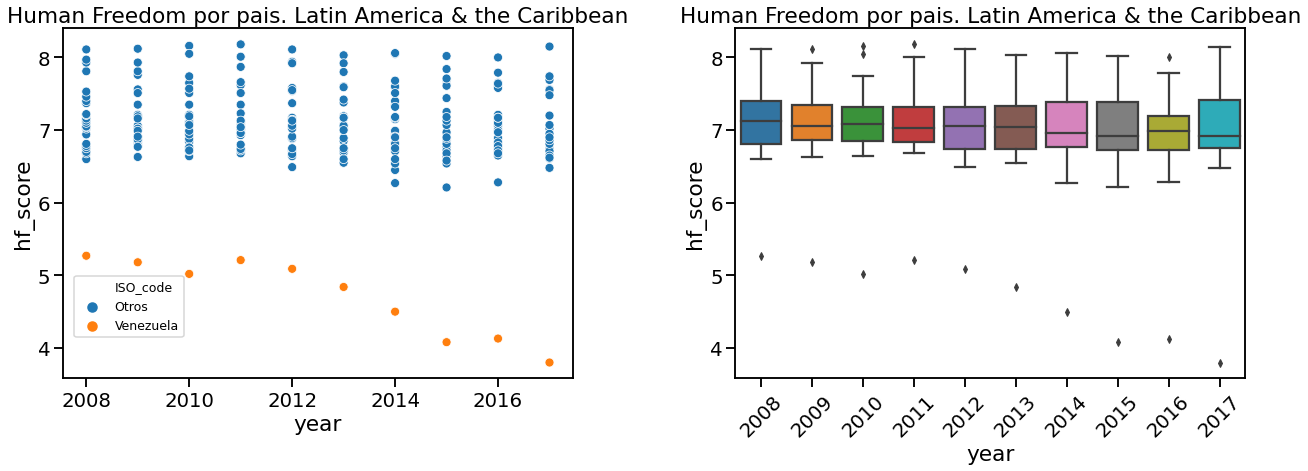

In [16]:
fig = plt.figure(figsize=(19,7))
columns = ['ISO_code','year', 'pf_identity', 'hf_score']
data = dataset[dataset.region == 'Latin America & the Caribbean'][columns]
data.ISO_code = data.ISO_code.apply(
    lambda x: "Venezuela" if x == "VEN" else "Otros" 
    )

sp2 = plt.subplot('121')
sp2.set_title("Human Freedom por pais. Latin America & the Caribbean")
seaborn.scatterplot(data=data, x='year', y='hf_score', hue='ISO_code', ax=sp2)
sp2.legend(loc='lower left',bbox_to_anchor=(0.01, 0.1),fontsize='xx-small')

sp3 = plt.subplot('122')
sp3.set_title("Human Freedom por pais. Latin America & the Caribbean")
seaborn.boxplot(data=data, x='year', y='hf_score', ax=sp3)
sp3.set_xticklabels(sp3.get_xticklabels(), rotation=45)

fig.tight_layout()


En este ejemplo observamos que, salvo por Venezuela, los valores para human freedom en los países de América Latina se encuentran más o menos centrados alrededor del valor promedio. Basados en esta observación, podríamos utilizar la media para comparar esta variable entre países dentro de esta región. Mientras que para comparar países que pertenecen a regiones diferentes deberíamos utilizar alguna otra medida de posición adicional a la media.

**ESTO ESTABA ESCRITO ANTES: En el ejemplo anterior vemos que Venezuela es un outlier muy notable en todos los años, seria mejor utilizar la mediana como medida mas robusta para comparar entre **regiones**, el resto de los paises de la region se mantienen dentro del mismo rango**

Solapando los histogramas de América Latina y el mundo para la variable human freedom (acumulada a lo largo de los años) lo primero que llama la atención es que, la distribución de América Latina es unimodal y más o menos simétrica (como demostramos anteriormente utilizando los box plot), mientras que la del Mundo es bimodal:

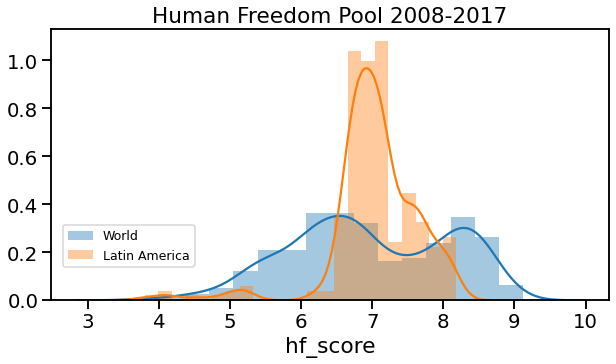

In [17]:
#Human freedom incluyendo todos los años desde 2008 a 2017, solapando America Latina y el Mundo
plt.figure(figsize=(10,5))
plt.title(label='Human Freedom Pool 2008-2017')
m = dataset.region.apply(lambda x: 'Latin America' in x)
seaborn.distplot(dataset[~m]['hf_score'], label='World')
seaborn.distplot(dataset[m]['hf_score'], label='Latin America')
plt.legend()
plt.legend(loc='lower left',bbox_to_anchor=(0.01, 0.1),fontsize='xx-small')



Los histogramas solapados de América Latina y el Mundo en 2008 y en 2017 muestran un patrón semejante al anterior.

```
# PARA 2008
min_year = 2008 #min(dataset.year.unique()) 
df_min_year= (dataset[dataset.year==min_year])

plt.figure(figsize=(10,5))
plt.title(label='Human Freedom 2008')
m = df_min_year.region.apply(lambda x: 'Latin America' in x)
seaborn.distplot(df_min_year[~m]['hf_score'], label='World')
seaborn.distplot(df_min_year[m]['hf_score'], label='Latin America')
plt.legend()
plt.legend(loc='lower left',bbox_to_anchor=(0.01, 0.1),fontsize='xx-small')

#PARA 2017
max_year = 2017 #max(dataset.year.unique()) 
df_max_year= (dataset[dataset.year==max_year])

plt.figure(figsize=(10,5))
plt.title(label='Human Freedom 2017')
m = df_max_year.region.apply(lambda x: 'Latin America' in x)
seaborn.distplot(df_max_year[~m]['hf_score'], label='World')
seaborn.distplot(df_max_year[m]['hf_score'], label='Latin America')
plt.legend()
plt.legend(loc='lower left',bbox_to_anchor=(0.01, 0.1),fontsize='xx-small')
```



Basados en los box plot e histogramas obtenidos para la variable human freedom, consideramos que podríamos utilizar la media para comparar esta variable entre países dentro de América Latina. Mientras que para comparar países que pertenecen a regiones diferentes deberíamos utilizar alguna otra medida de posición adicional a la media.

Por otro lado, dada la naturaleza de las variables de libertad de identidad (discretas con 3 ó 4 valores posibles, asignados a modo de categorías), una manera a través de la cual se podría comparar estas variables entre países es utilizando la moda (valor más frecuente de la variable a lo largo de los años, en este caso) o directamente la distribución de frecuencias acumuladas a lo largo de los años de esta variable para cada país a comparar. En el mismo sentido, como el índice pf_identity es un promedio de estas variables discretas-categóricas, también tiene pocos valores posibles y sería mejorar comparar esta variable entre países utilizando la moda o una distribución de frecuencias acumulada.

### 1.3. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. Usar la respuesta del punto anterior para justificar si la comparación es válida o no.

In [18]:
result = dataset.copy()
result.region = result.region.apply(
    lambda x: 'World' if 'Latin America' not in x  else x
)
columns_3 = ['pf_identity', 'hf_score', 'region']
result = result[columns_3]
result.groupby(['region']).agg(
    ['count', pd.Series.mode, 'median', 'mean','std']
    )

pf_identity        ...  hf_score          
                                    count  mode  ...      mean       std
region                                           ...                    
Latin America & the Caribbean         258  10.0  ...  7.036977  0.634897
World                                1282  10.0  ...  6.966388  1.121887

[2 rows x 10 columns]

Anteriormente vimos que en América Latina la variable `hf_score` tiene una distribución unimodal más o menos simétrica (con media, mediana y moda coincidentes). Mientras que la distribución de esta variable en el mundo (sin América Latina) es bimodal (con media y mediana cercanas pero no coincidentes y con dos modas una cerca de 6.24, y la otra 8.25). De este modo, el valor promedio en América Latina representa aquel valor de `hf_score` presentado por la mayor cantidad de los datos. Contrariamente, el valor promedio en el Mundo está influido por valores extremos más frecuentes que los demás valores de la variable (es decir, países o años con valores de la variable muy bajos o muy altos). En este sentido, la comparación de esta variable entre América Latina y el Mundo a través de una única medida de tendencia central como la media (aunque sean parecidas entre América Latina y el Mundo), no es válida, ya que no caracteriza de manera adecuada el comportamiento de `hf_score` en ambos conjuntos de datos.


**Editado**

En base las observaciones 

*{"La comparación de pf_identity es válida porque las distribuciones se
parecen?" En principio puede ser buena justificación para comparar pero podría considerarse la comparación año por 
año como hicieron en sección anterior pues pude ser que los valores antes 
de la media en una región sean en los primeros años y en la otra los posteriores, con lo cual la variable año podría ser un factor influyente 
en la comparación}*





In [21]:
result = dataset.copy()
result.region = result.region.apply(
    lambda x: 'World' if 'Latin America' not in x  else x
)
columns_3 = ['pf_identity', 'hf_score', 'region', 'year']
result = result[columns_3]
result.groupby(['region', 'year']).agg(
    ['count', pd.Series.mode, 'median', 'mean','std']
    )

pf_identity               ...  hf_score          
                                         count         mode  ...      mean       std
region                        year                           ...                    
Latin America & the Caribbean 2008          25           10  ...  7.130000  0.568272
                              2009          25           10  ...  7.112000  0.560454
                              2010          26           10  ...  7.087692  0.582658
                              2011          26           10  ...  7.090000  0.561989
                              2012          26           10  ...  7.049615  0.584127
                              2013          26           10  ...  7.027308  0.606963
                              2014          26           10  ...  7.005769  0.687547
                              2015          26          6.7  ...  6.960000  0.742649
                              2016          26  [6.7, 10.0]  ...  6.962308  0.711934
                              2017          26  [6.7, 10.0]  ...  6.951538  0.771693
World                         2008         116           10  ...  7.066810  1.105089
                              2009         116           10  ...  7.076810  1.062468
                              2010         127           10  ...  7.024567  1.063805
                              2011         127           10  ...  6.999134  1.103764
                              2012         127           10  ...  6.963386  1.120218
                              2013         131           10  ...  6.958855  1.109343
                              2014         133           10  ...  6.939023  1.148604
                              2015         133            9  ...  6.914887  1.170713
                              2016         136            9  ...  6.879412  1.173086
                              2017         136            9  ...  6.875809  1.158729

[20 rows x 10 columns]

Variable año es un influyente en la comparación tanto para 
`pf_identity` para america latina el valor de la 
mediana desde el 2008 a 2014 es de 10 y luego 6.70, mietras que para
el resto del mundo solo varian los dos ultimos años.
Para `hf_score` para america latina se repite el comportamiento desde 
el 2008-2013 en un extremo de la mediana global y desde el 2014 en 
adelante, el extremo restante. Para el resto del mundo 
desde 2008 al 2014 se encuentra debajo del mediana global mietras que desde
el 2015 se ecuentran por arriba. 

### 1.4. ¿Tiene sentido calcular la moda?

Por lo visto en el histograma para la variable `pf_identity`, la moda será semejante en América Latina y en el Mundo (aunque con diferentes frecuencias).

Contrariamente, la moda de la variable `hf_score` será diferente en América Latin respecto al mundo (el cual que presentará dos modas). En este caso, el cálculo de la moda, sí aportará información adicional sobre la distribución de la variable en cada una de las regiones.

**Editado**

En base las observaciones 

*En en este tipo de variables no tiene mucho sentido la moda. Es más adecuada para datos categóricos.*



### 1.5. ¿Cómo pueden sanearse los valores faltantes?

Los valores faltantes podrian sanearse usando inferencia:

  * **Calculo de Media/Mediana**
     
     Sanear esos valores calculando la meadia/meadiana usando los valores
     existentes para una variable de un pais y replazando los valores faltantes
     con el calculo realizado.
     Tiene como ventaja de ser un metodo simple. Sin embargo la inferencia de 
     una variable no tiene en cuenta las correlaciones con las demas.
     
     Por ejemplo si usamos este metodo para `Suriname` que tiene datos faltantes
     para los años 2008 y 2009. Pero por otro lado el caso de `Iraq` que tiene
     datos solamente para el 2017 y 2018, este metodo es menos apropiado 
     que eliminar directamente las entradas.
     
  * **Aproximacion usando vecinos cercanos**
     
     Este enfoque plantea usar la informacion de los paises vecinos
     pertenecientes a una misma region, los cuales pueden tener carateristicas
     similares. Si tomamos el mismo ejemplo anterior `Suriname` se la puede
     relacionar con `Guyana` o `Iraq` con `Iran`, aun asi tienen valores 
     distintos en cuanto libertades de identidad (ejm. `pf_identity`). 
     Por otro lado las similitudes de `Suriname` con otros vecinos como 
     `Venezuela` o `Brasil` son mimimas. Al igual que el uso de la media/mediana
     no tiene encuenta las correlaciones con las otras variables.
     
  * **Regresion**
     
     Utilizar Regresion puede ser un buen enfoque ya que refleja tendencias,
     Pero se necesita un minimo de muestras, por ejemplo para el caso de `Iraq` solo se 
     tienen dos muestras.

### 1.6. ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? Los outliers, ¿son globales o por grupo? ¿Los eliminaría del conjunto de datos?

#### Respecto a HF_SCORE

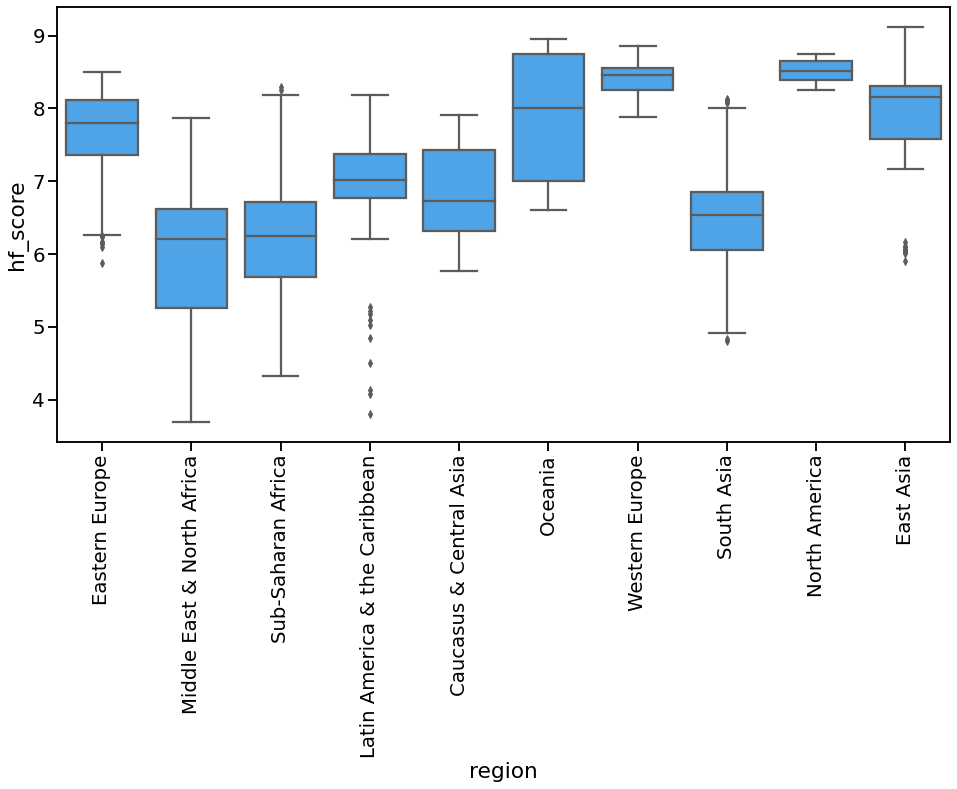

In [27]:
fig = plt.figure(figsize=(16, 8))

sp1 = plt.subplot('111')
seaborn.boxplot(data=dataset, x='region', y='hf_score', color='#35A7FF', ax=sp1)
#seaborn.despine()
sp1.set_xticklabels(sp1.get_xticklabels(), rotation=90)
plt.show()

fig.tight_layout()


Vemos que pareciera haber grupos de outliers muy notorios en el caso del Este de Asia y Ameria Latina & el Caribe, sin elmbargo en el proximo grafico vemos que estos "grupos" son enrealidad datos del mismo pais, pero como estan "aplanados" los datos de todos los años parecieran ser un grupo de paises.

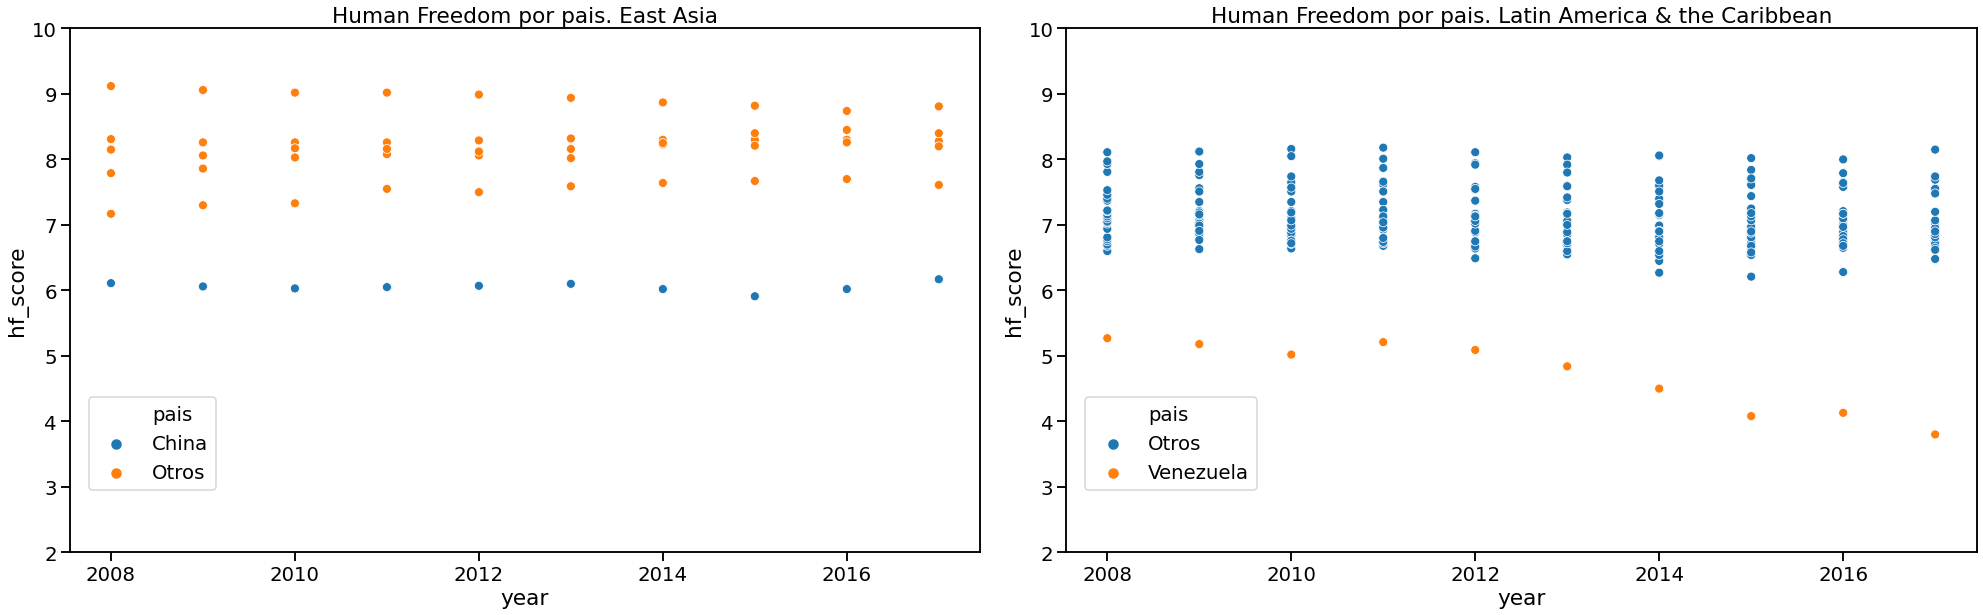

In [45]:
fig = plt.figure(figsize=(28, 9))

data = dataset[dataset.region == 'Latin America & the Caribbean'][['ISO_code','year', 'pf_identity', 'hf_score']]
data2 = dataset[dataset.region == 'East Asia'][['ISO_code','year', 'pf_identity', 'hf_score']]

data2['pais'] = data2.ISO_code.apply(lambda x: "China" if x == "CHN" else "Otros" )

sp3 = plt.subplot('121')
sp3.set_title("Human Freedom por pais. East Asia")
seaborn.scatterplot(data=data2, x='year', y='hf_score', hue='pais', ax=sp3)
sp3.legend(loc='lower left',bbox_to_anchor=(0.01, 0.1))
sp3.set_ylim(2,10)

data['pais'] = data.ISO_code.apply(lambda x: "Venezuela" if x == "VEN" else "Otros" )

sp2 = plt.subplot('122')
sp2.set_title("Human Freedom por pais. Latin America & the Caribbean")
seaborn.scatterplot(data=data, x='year', y='hf_score', hue='pais', ax=sp2)
sp2.legend(loc='lower left',bbox_to_anchor=(0.01, 0.1))
sp2.set_ylim(2,10)

fig.tight_layout()

En estos dos casos particulares, America latin y el este de Asia, vemos claramete como China y Venezuela son outliers en su region y siempre siempre han sido outliers a travez de los años.

En cuanto a la desicion de quitar o no los outliers debe tomarse cuidadosamente de acuerdo a la region que se esta tratando, en el grafico de East Asia se ve claramente que China es un outlier, pero quitar este pais del dataset puede conllevar a un sesgo enorme la region East Asia comprende solo 6 paises osea que eliminar China representaria quitar el 15% de los datos de la region, por otro lado la cantidad de habitantes de China representa mas del 80% de la poblacion de la region.
En el caso de America Latina y El Caribe, nuestro caso de interes, Venezuela es un notable outlier, su poblacion representa menos del 5% de la poblacion de la Region y su indice no refleja las tendencias de la region.


#### Respecto a PF_Identity

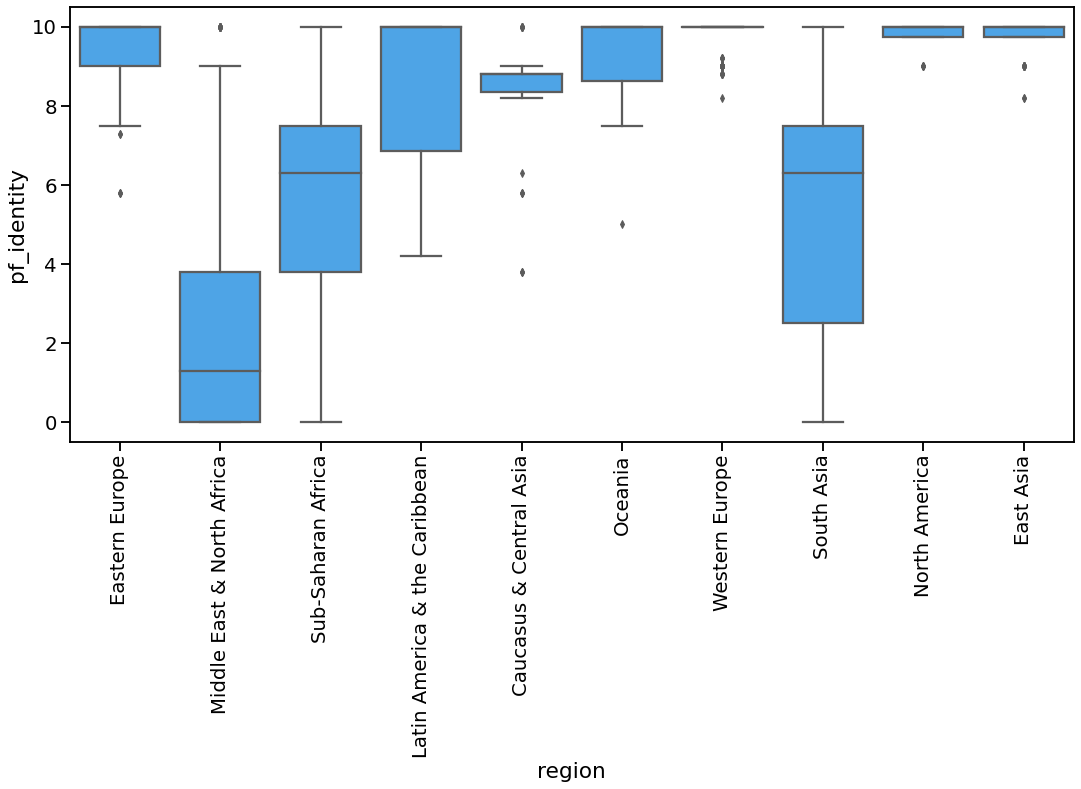

In [28]:
fig = plt.figure(figsize=(18, 8))

sp1 = plt.subplot('111')
seaborn.boxplot(data=dataset, x='region', y='pf_identity', color='#35A7FF', ax=sp1)
#seaborn.despine()
sp1.set_xticklabels(sp1.get_xticklabels(), rotation=90)
plt.show()

fig.tight_layout()

Los outliers en el caso de pf_identity son aislados correspondientes a mediciones 'inusuales' en algun año de la serie mientras que el resto de los paises mantiene el el mismo rango, seria correcto quitarlos de la region de estudio pero no a nivel global, ya que como vemos este valor se distribuye a lo largo de todo el rango posible

## 2. Agregación de datos

1. Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.
2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?
3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable *pf_identity* en la región. ¿Cómo seleccionarion los países relevantes a esa tendencia?

Pista: hay gráficos de seaborn que permiten generar visualizaciones para cada valor de una variable categórica, en este caso, las distintas regiones.

Sólo por curiosidad, graficar la tendencia de *hf_score* y *ef_score* a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

### 2.1. Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.


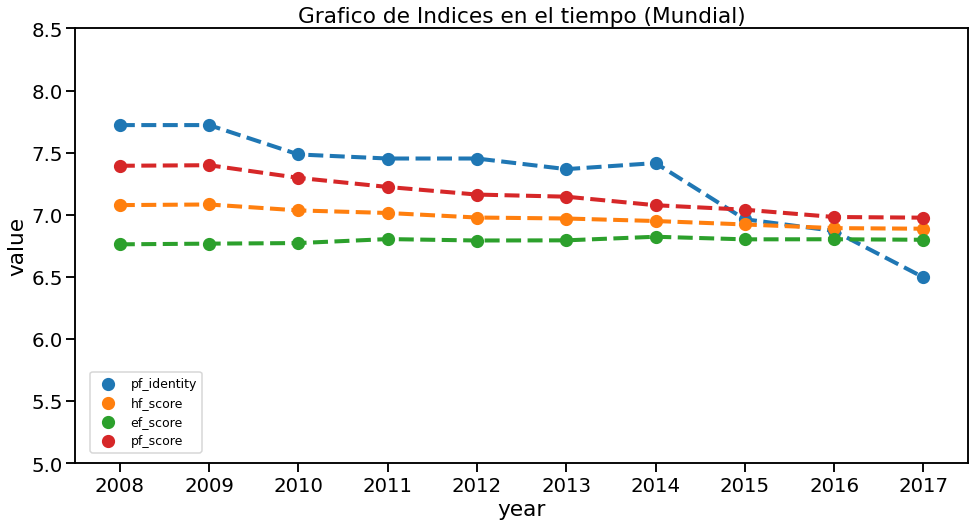

In [50]:
fig = plt.figure(figsize=(16, 8))
data = dataset[[ 'year','ISO_code', 'pf_identity', 'hf_score','ef_score','pf_score']]

sp1 = plt.subplot('111')
sp1.set_title('Grafico de Indices en el tiempo (Mundial)')
seaborn.pointplot(
    x='year', y='value',
    data=pd.melt(data, ['year'],['pf_identity', 'hf_score','ef_score','pf_score']), 
    hue='variable', ci=None, estimator=np.mean,
    markers='o', linestyles='--', ax=sp1
)
sp1.legend(loc='lower left',bbox_to_anchor=(0.01, 0.01),fontsize='xx-small')
sp1.set_ylim(5, 8.5)
plt.show()

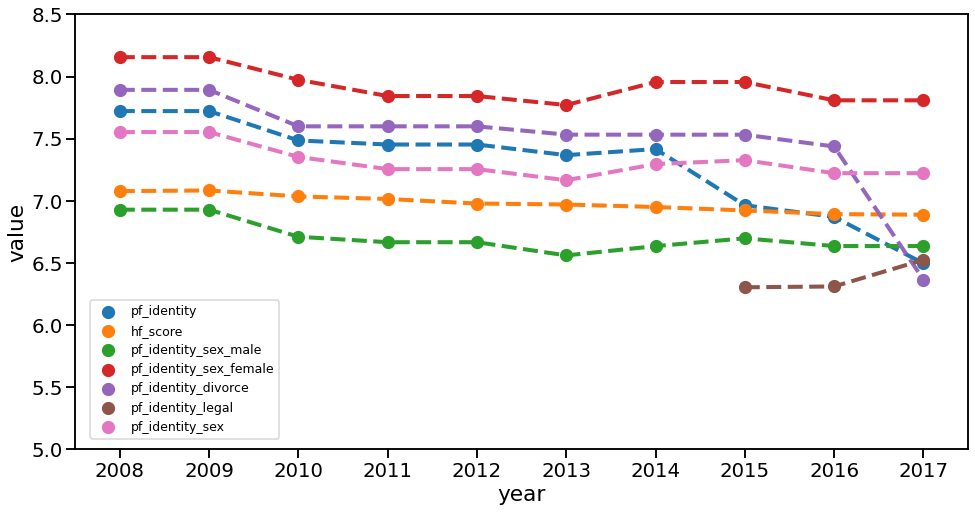

In [51]:
fig = plt.figure(figsize=(16, 8))
data = dataset[[ 'year','ISO_code', 'pf_identity', 'hf_score','pf_identity_sex_male', 'pf_identity_sex_female', 'pf_identity_divorce','pf_identity_legal', 'pf_identity_sex']]

sp1 = plt.subplot('111')
seaborn.pointplot(
    x='year', y='value',
    data=pd.melt(data, ['year'], ['pf_identity', 'hf_score','pf_identity_sex_male', 'pf_identity_sex_female', 'pf_identity_divorce','pf_identity_legal', 'pf_identity_sex']), 
    hue='variable', ci=None, estimator=np.mean,
    markers='o', linestyles='--', ax=sp1
)
sp1.legend(loc='lower left',bbox_to_anchor=(0.01, 0.01),fontsize='xx-small')
sp1.set_ylim(5, 8.5)
plt.show()

### 2.2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?

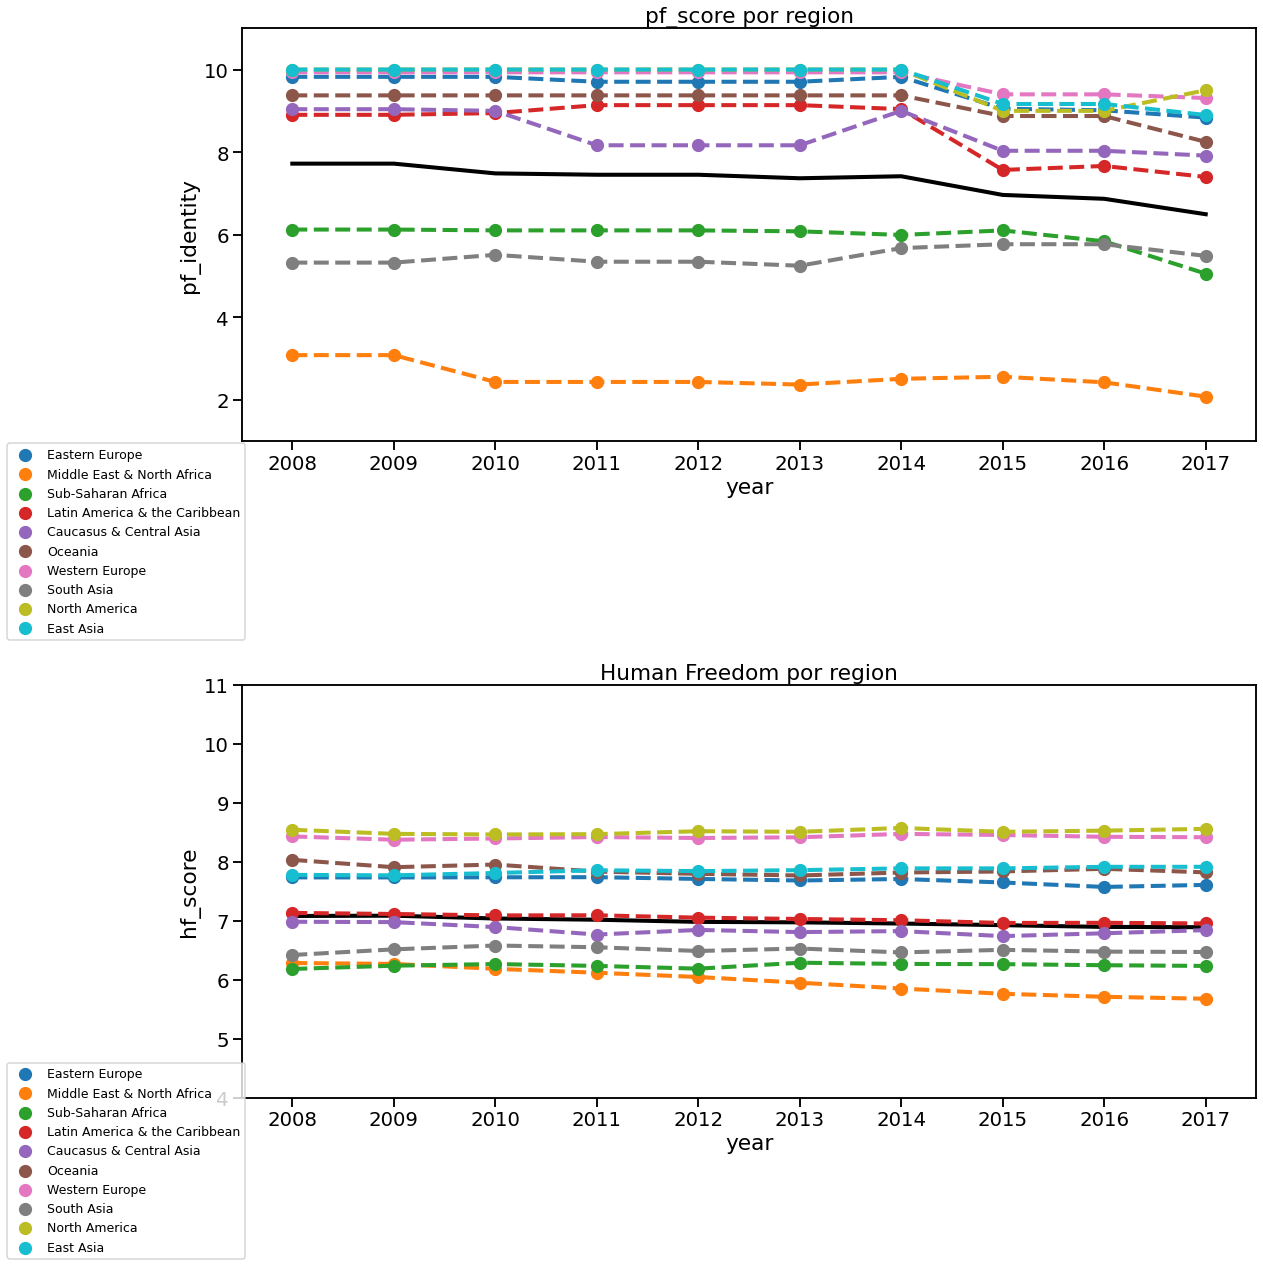

In [71]:
fig = plt.figure(figsize=(18,18))

data = dataset[['region', 'year', 'pf_identity', 'hf_score']]

sp1 = plt.subplot('211')
sp1.set_title("pf_score por region")
seaborn.pointplot(data=data, x='year', y='pf_identity', hue='region', 
                  ci=None, estimator=np.mean, ax=sp1,
                  markers='o', linestyles='--'
                  )

seaborn.pointplot(data=data, x='year', y='pf_identity',  
                  ci=None, estimator=np.mean, ax=sp1,
                  markers='', linestyles='-', color='black' 
                  )

sp1.set_ylim(1, 11)
sp1.legend(loc='best',bbox_to_anchor=(0.01, 0.01),fontsize='xx-small')

sp2 = plt.subplot('212')
sp2.set_title("Human Freedom por region")
seaborn.pointplot(data=data, x='year', y='hf_score', hue='region', ci=None, 
                 estimator=np.mean, ax=sp2,
                  markers='o', linestyles='--'
                  )

seaborn.pointplot(data=data, x='year', y='hf_score',  
                  ci=None, estimator=np.mean, ax=sp2,
                  markers='', linestyles='-', color='black' 
                  )

sp2.set_ylim(4, 11)
sp2.legend(loc='best',bbox_to_anchor=(0.01, 0.1),fontsize='xx-small')

fig.tight_layout()

**En relación a la libertad de identidad (pf_identity):**

La línea negra sólida en el gráfico representa el promedio mundial para la variable Libertad de Identidad (`pf_identity`).
La tendencia global para la libertad de identidad es decreciente desde el comienzo de los registros hasta el final (2008 a 2017), con dos períodos en los cuales la dicho decrecimiento fue más pronunciado: entre 2014 y 2015, y entre 2016 y 2017. En las regiones que exhibían un promedio de Libertad de Identidad por encima del promedio mundial, también se observó esa pronunciada caída entre los años 2014 y 2015. Graficando cada una de las variables de identidad personal por separado (**Ver a continuación**) detectamos que esa caída estuvo asociada a la incorporación de la variable `pf_identity_legal` en el cálculo de la libertad de identidad. Como la variable `pf_identity_legal` tomó valores extremadamente bajos, por la ley de los grandes números, arrastró el promedio de libertad
de identidad hacia abajo. Contrariamente, en las regiones con libertad de identidad por debajo del promedio, la incorporación de esa variable no afectó el índice de libertad de identidad. 
Otra región que muestra un patrón diferente al promedio mundial fue Caucasus & Central Asia entre los años 2011 y 2013, que estuvo asociado a **xxx**

**En relación a human freedom**
La línea negra sólida en el gráfico representa el promedio mundial para la variable Libertad de Humana (`hf_score`). 
La tendencia mundial para esta variable es decreciente. Mientras que para las regiones que tienen valores de `hf_score` por encima del promedio esta variable parece que se mantiene constante a lo largo del tiempo, para las regiones con valores de `hf_score` por debajo del promedio parece presentar una tendencia decreciente.

## 3. Distribuciones
  1. Graficar en un mismo histograma la distribución de la variable *pf_identity* en global, y en Latinoamérica y el caribe. Repetir para la variable *hf_score*. ¿Visualmente, a qué tipo de distribución corresponde cada variable? ¿Es correcto utilizar todos el conjunto de valores disponibles para esa region en estos gráficos?


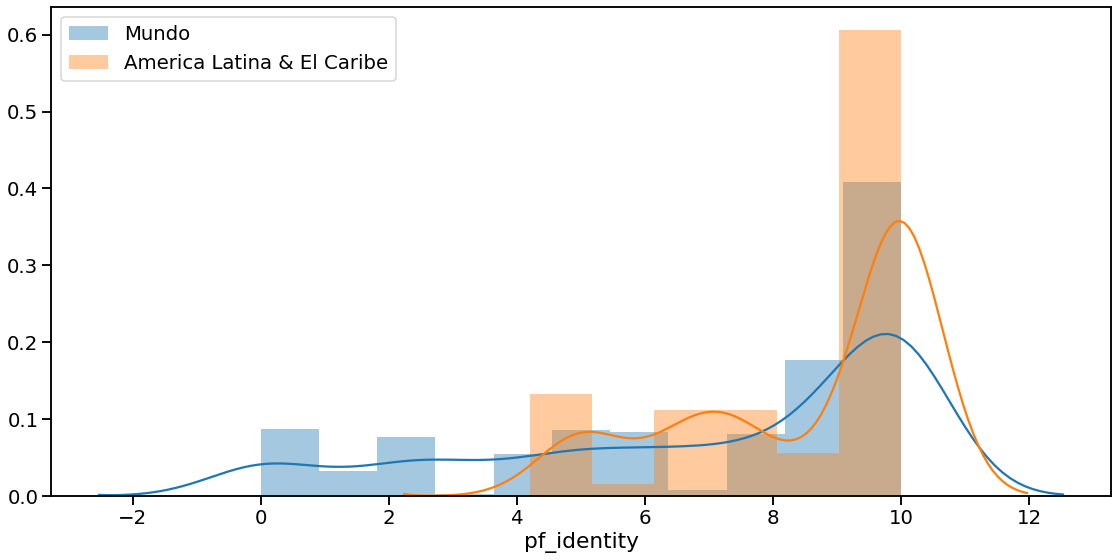

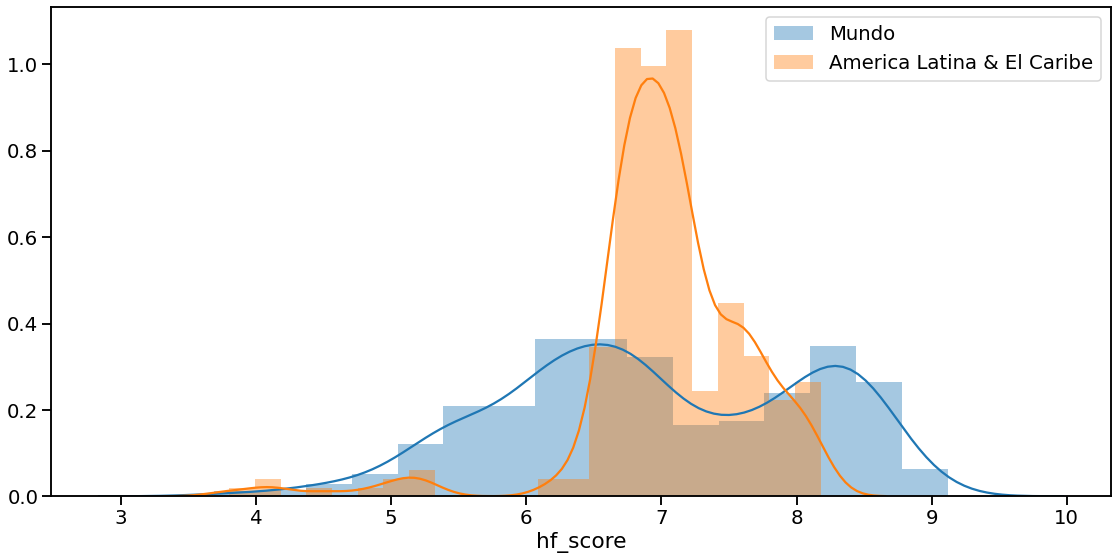

In [72]:
plt.figure(figsize=(19,9))
latam = dataset.region == 'Latin America & the Caribbean'

seaborn.distplot(dataset.pf_identity[~latam], label='Mundo')
seaborn.distplot(dataset.pf_identity[latam], label='America Latina & El Caribe')

plt.legend()

plt.figure(figsize=(19,9))

seaborn.distplot(dataset.hf_score[~latam], label='Mundo')
seaborn.distplot(dataset.hf_score[latam],
                 label='America Latina & El Caribe')

plt.legend()

En el caso de la variable *hf_score* en América Latina y el Caribe, el gráfico de la distribución nos muestra que hay valores a la izquierda que se alejan de la mayoria y podrian ser considerados como outliers. Estos datos corresponden a Venezuela. Para la variable *pf_identity* los outliers no se ven claramente en su grafico de distribución.

## 4. Correlaciones y Relaciones

En este ejercicio queremos responder a las preguntas

* Las libertades personales y económicas, ¿van siempre de la mano?
* ¿Cómo se relacionan ambas con las libertades respectivas a las relaciones personales?

Para ello, analizaremos las correlaciones entre las variables pf_identity, pf_score y ef_score. 

Como pf_indentity contribuye al cálculo de pf_score esperamos hallar algún grado de correlación. Lo contrario podría ocurrir con ef_score. 

1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?
2. Graficar la correlación (visual) entre pf_identity y pf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en la práctica, discreta, y eso afecta al tipo de gráfico que podemos usar.
3. Convertir estas variables en categóricas, es decir, a partir de pf_indentity generar otra variable pf_identity_segment que tome los valores `high`, `medium` y `low`. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como `pandas.cut` o `pandas.dcut`. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles.
4. Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables.



### 4.1 ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?

Pairplot

<Figure size 432x288 with 0 Axes>

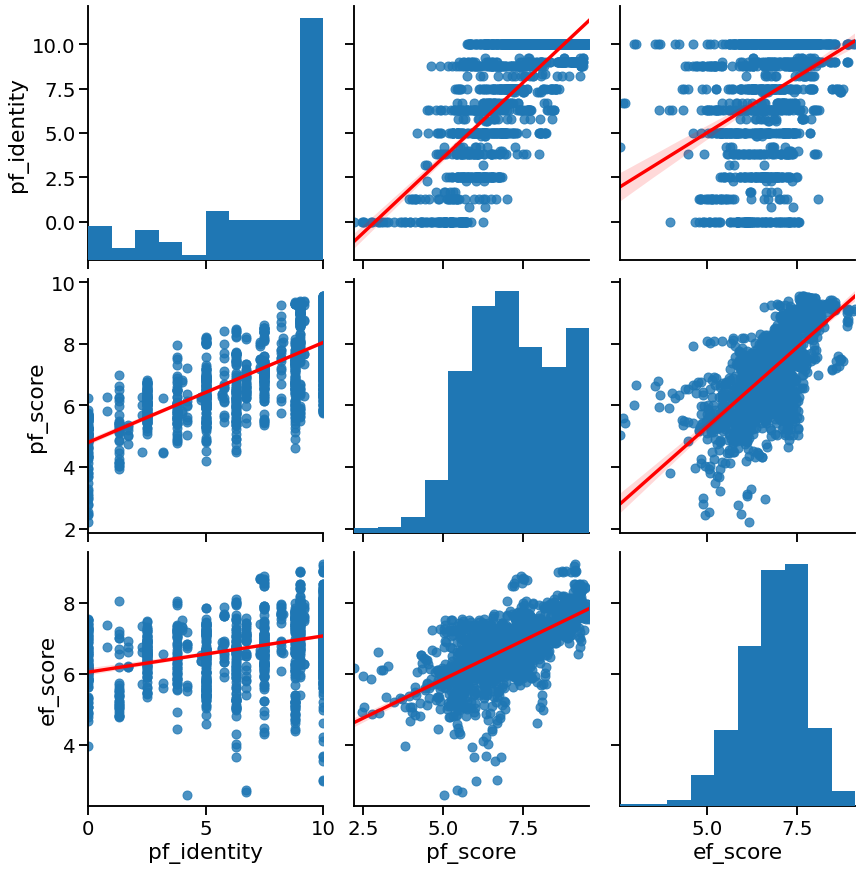

In [73]:
fig = plt.figure()
seaborn.pairplot(dataset, vars=["pf_identity", "pf_score", "ef_score"], 
                  kind="reg", dropna=True,
                 height=4,
                 plot_kws={'line_kws':{'color':'red'}}
)
plt.show()

In [ ]:
lgress = stats.linregress(
    dataset[['pf_identity', 'pf_score']].dropna(),
)
print("r_value**2 :{}".format(lgress.rvalue**2))

r_value**2 :0.5508735760824914


El grafico muestra que exite una relacion con una pendiente positva entre `pf_indentity` y `pf_score`.Pero teniendo en cuenta el resultado anterior, no se puede afirmar que esta sea relacion lineal simple ya que solo el 55% (`r_value**2`) se comporta de esta manera. Esto se debe a que `pf_identity` solo contribuye 5% al valor de `pf_score`.

In [ ]:
lgress = stats.linregress(
    dataset[['ef_score', 'pf_score']].dropna(),
)
print("r_value**2 :{}".format( lgress.rvalue**2))

dataset[['pf_score',  'ef_score']].corr(method="kendall")

r_value**2 :0.453821749932265


,pf_score,ef_score
pf_score,1.000000,0.517037
ef_score,0.517037,1.000000


En el grafico se muestra una aparente relacion entre `hf_score` y `ef_score`, que luego es validad mediante el test `kendall` el cual muestra que la relacion tiene una pendiente positiva. Esto apunta a en paises donde existe mayor libertad economica tambien tienen valores altos para la libertad personal.

Por otro lado si se analiza el coeficiente de determinacion (`r_value**2`) no se puede afirmar las variables tengan una relacion lineal simple, ya que el modelo solo explica un 45 % de la variable real.

In [ ]:
lgress = stats.linregress(
    dataset[['ef_score', 'pf_identity']].dropna(),
)
print("r_value**2 :{}".format( lgress.rvalue**2))

r_value**2 :0.128989470933827


No se esta de acuerdo en comparar `pf_identity` con `ef_score` ya que el coeficiente de determinación (`r_value**2`) es cercano a 0. Tampoco con `hf_score` ya que los datos de `pf_identity` son valores discretos. 

### 4.2 Graficar la correlación (visual) entre pf_identity y pf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? 

Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en la práctica, discreta, y eso afecta al tipo de gráfico que podemos usar.

Los graficos necesarios son los Heatmap este punto se resuleve gracias a los puntos 4.3 y 4.4 

### 4.3 Convertir estas variables en categóricas,

es decir, a partir de pf_indentity generar otra variable pf_identity_segment que tome los valores high, medium y low. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como pandas.cut o pandas.dcut. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles.

In [75]:
def mk_cut(ds,bins):
    return pandas.cut(ds, bins=bins, labels=["low", "medium" ,"high"], include_lowest=True)

pf_identity_segment = mk_cut(dataset.pf_identity.dropna(), bins=[0,5,8.8,10])
ef_score_segment = mk_cut(dataset.ef_score.dropna(), bins=[2.58,6.22,6.88,9.12])
pf_score_segment = mk_cut(dataset.pf_score.dropna(), bins=[2.22,6.14,7.145,9.56])

ds = pd.DataFrame()
ds['pf_identity_segment'] = pf_identity_segment
ds['pf_score_segment'] = pf_score_segment
ds['ef_score_segment'] = ef_score_segment

### 4.4 Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). 

Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables.

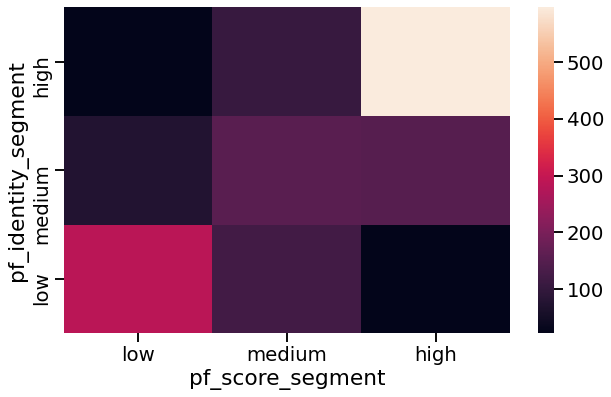

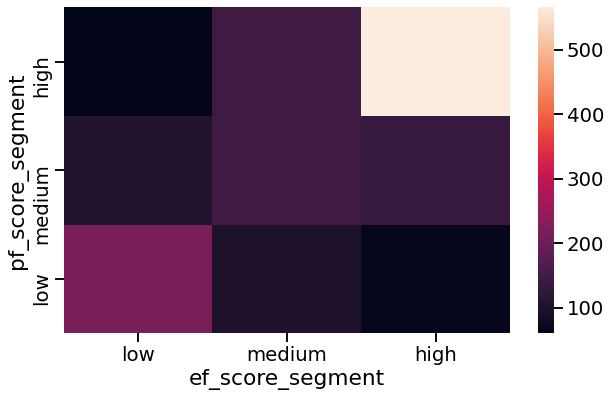

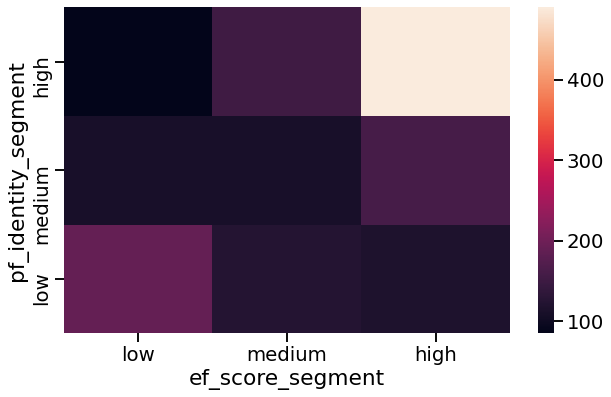

In [76]:
plt.figure(figsize=(10,6))
exp = pandas.crosstab(ds.pf_identity_segment, ds.pf_score_segment)
ax = seaborn.heatmap(exp)
ax.invert_yaxis()
plt.figure(figsize=(10,6))
exp = pandas.crosstab(ds.pf_score_segment, ds.ef_score_segment)
ax = seaborn.heatmap(exp)
ax.invert_yaxis()
plt.figure(figsize=(10,6))
exp = pandas.crosstab(ds.pf_identity_segment, ds.ef_score_segment)
ax = seaborn.heatmap(exp)
ax.invert_yaxis()

# Parte 2

Luego del segundo fin de semana de clase, podemos revisitar nuestro trabajo anterior y completarlo respondiendo a las siguientes preguntas:

## 3. Distribuciones

2. Realizar una prueba de Kolmogorov-Smirnof para comprobar analíticamente si estas variables responden la distribución propuesta en el ejercicio anterior. Hint: podés usar https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html, pero hay que tener en cuenta que si la distribución es "norm", entonces va a comparar los datos con una distribución normal con media 0 y desviación estándar 1. Se puede utilizar la distribución sobre todos los datos o sólo sobre Latinoamérica.

El gráfico de la kde de la variable pf_identity en Latinoamérica sugiere una distribución exponencial. A continuación, descartamos esta hipótesis:

In [77]:
data2 = dataset[dataset.region == 'Latin America & the Caribbean'].copy()
x = data2.pf_identity.apply(lambda x: (10 - x))
x = x.dropna()
desc = x.describe()
mean =  desc['mean']
std = desc['std']
x.to_numpy()
stats.kstest(x,'expon',args=[1/mean])

KstestResult(statistic=0.5736434108527132, pvalue=6.531278237901983e-81)

Descartando los valores Outliers correspondientes a las mediciones de Venezuela, obtenemos que tampoco ajusta: 

In [78]:
data2 = dataset[dataset.region == 'Latin America & the Caribbean'][dataset.ISO_code != 'VEN'].copy()
x = data2.pf_identity.apply(lambda x: (10 - x))
x = x.dropna()
desc = x.describe()
mean =  desc['mean']
std = desc['std']
x.to_numpy()
stats.kstest(x,'expon',args=[1/mean])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


KstestResult(statistic=0.5685483870967742, pvalue=2.72353313505844e-76)

Para la variable *hf_score* en el mundo observamos que responde a una distribución bimodal de las cuáles no hemos estudiado ninguna, por lo tanto, buscamos caracterizar el comportamiento de distintos secotres observados separando en dos grupos: aquellos que se encuentran por encima de la mediana y aquellos que se encuentran por debajo:

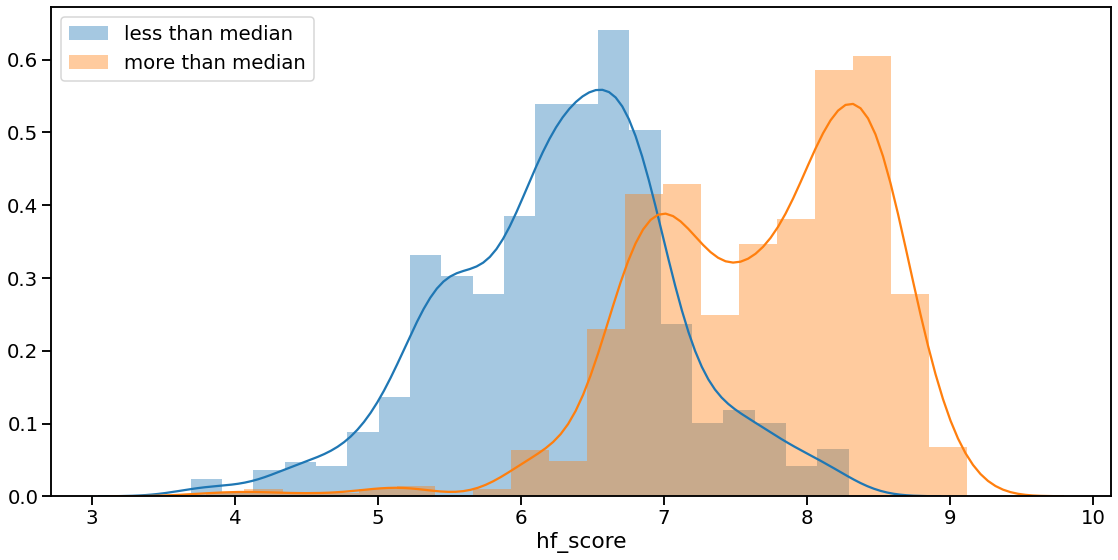

In [79]:
plt.figure(figsize=(19,9))
mu = dataset.hf_score.median() 
fil = dataset.groupby(['region']).median().hf_score <= mu
fil = fil[fil].index.values

tesframe = dataset[dataset.region.isin(fil)].hf_score

seaborn.distplot(dataset[dataset.region.isin(fil)].hf_score, 
             label='less than median')
seaborn.distplot(dataset[~dataset.region.isin(fil)].hf_score, 
             label='more than median')

plt.legend()

Observamos que los datos que se hallan por debajo de la mediana, se asemejan más a una distribución `normal` en tanto los que están por encima siguen siendo bimodales. Aplicamos ahora el test K-S al primer grupo noramlizando (es decirr, restando la media y luego dividiendo por la desviación estándar) los datos:

In [80]:
tesframe = tesframe.dropna()
tesframe = (tesframe - tesframe.mean()) / tesframe.std()
stats.kstest(tesframe, 'norm')

KstestResult(statistic=0.04732586845512665, pvalue=0.06152330351026416)

De lo anterior, obtenemos que el test no es suficiente para descartar la Hipótesis nula, por lo tanto no podemos decir que no es normal. 

## 4. Correlaciones

3. Calcular algún coeficiente de correlación adecuado entre los dos pares de variables, dependiendo de la cantidad de datos, el tipo de datos y la distribución de los mismo. Algunas opciones son: coeficiente de pearson, coeficiente de spearman, coeficientes de tau y de kendall. Interpretar los resultados y justificar si las variables están correlacionadas o no. 


El coeficiente de Pearson muestra un grado considerable de correlación cuantitativa entre *pf_identity* 
y *pf_score*.


In [ ]:
dataset[['pf_identity',  'pf_score']].corr(method="pearson")

,pf_identity,pf_score
pf_identity,1.000000,0.742209
pf_score,0.742209,1.000000


La correlación ordinal, que no es afectada por outliers, también muestra que las variables están correlacionadas:

In [ ]:
dataset[['pf_identity',  'pf_score']].corr(method="spearman")

,pf_identity,pf_score
pf_identity,1.000000,0.731358
pf_score,0.731358,1.000000


In [ ]:
dataset[['pf_identity',  'pf_score']].corr(method="kendall")

,pf_identity,pf_score
pf_identity,1.000000,0.567114
pf_score,0.567114,1.000000


Por otro lado, ambas medidas muestran que la correlación entre pf_identity y ef_score no es signficativa en comparación con la anterior. No podemos descartar con estas medidas una correlación no linear entre las variables.

In [ ]:
dataset[['pf_identity',  'ef_score']].corr(method="pearson")

,pf_identity,ef_score
pf_identity,1.000000,0.359151
ef_score,0.359151,1.000000


In [ ]:
dataset[['pf_identity',  'ef_score']].corr(method="spearman")

,pf_identity,ef_score
pf_identity,1.000000,0.400777
ef_score,0.400777,1.000000


In [ ]:
dataset[['pf_identity',  'ef_score']].corr(method="kendall")

,pf_identity,ef_score
pf_identity,1.000000,0.284226
ef_score,0.284226,1.000000


4. [Opcional] Hay dos opciones, o hacer un test para correlación de categóricas, o usar otro par de variable que se pueda hacer ordinal usando pandas.cut y aplicar Kendall.

En función de lo observado en el apartado de **Distribuciones**, nos resultó interesante cuestionarnos sobre la existencia de una correlación entre las variables *pf_identity* y *hf_score* utilizando los métodos de *Pearson* y *Spearman*, verificando que existe y es de considerar: 

In [ ]:
dataset[['pf_identity',  'hf_score']].corr(method="pearson")

,pf_identity,hf_score
pf_identity,1.000000,0.643354
hf_score,0.643354,1.000000


In [ ]:
dataset[['pf_identity',  'hf_score']].corr(method="spearman")

,pf_identity,hf_score
pf_identity,1.000000,0.649334
hf_score,0.649334,1.000000


**Anuncio general**: El punto 4.4 de la parte 1 en el práctico es un horror! Felicitaciones a los grupos que se dieron cuenta de que lo que está escrito no tiene ningún sentido, no sé cómo se me pasó. Veamos, region NO ES ORDINAL, y no hay forma de hacerlo ordinal. El test Tau-Kendall es para variables ordinales o rankings, así que no se aplica a region. 

Además de completar estos puntos faltantes, luego de haber visitado los conceptos de percepción visual y comunicación efectiva, están en condiciones de reveer los gráficos realizados y evaluar si pueden ser mejorados. Para ello, puede hacerse las siguientes preguntas:

* ¿Están utilizando el tipo de gráfico adecuado para cada tipo de variable?
* Los gráficos, ¿son legibles?
* Los gráficos generados, ¿responden a las preguntas mostrando un patrón claro? En caso de que no, ¿podemos filtrar los datos para que el patrón sea más evidente? ¿o agruparlos de manera distinta? ¿o cambiar el tipo de gráfico?